In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, DistilBertModel
import numpy as np
import matplotlib.pyplot as plt

/Users/mattelim/miniforge3/envs/6861/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create a simple torch model with 1 fully connected layer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)

    def forward(self, x):
        # apply relu on the output of the fully connected layer
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

In [3]:
words = [
    "apple", "book", "car", "dog", "cat", "house", "tree", "friend", "time", "money",
    "heart", "sun", "moon", "sky", "water", "fire", "earth", "flower", "city", "music",
    "child", "parent", "school", "job", "love", "smile", "day", "night", "star", "cloud",
    "bird", "fish", "food", "computer", "phone", "internet", "coffee", "tea", "shoes", "hat",
    "dream", "goal", "team", "game", "hope", "fear", "joy", "anger", "peace", "war",
    "friendship", "family", "health", "beauty", "knowledge", "power", "nature", "history", "science",
    "art", "happiness", "sadness", "color", "mind", "body", "soul", "memory", "experience", "idea",
    "faith", "truth", "lie", "problem", "solution", "question", "answer", "light", "darkness", "wind",
    "rain", "snow", "smell", "taste", "touch", "sound", "silence", "joy", "freedom", "future",
    "past", "present", "purpose", "journey", "adventure", "discovery", "challenge", "victory", "defeat"
]

most_common_words = []

# remove duplicates
words = list(set(words))
most_common_words = list(set(most_common_words))

print(len(words))
print(len(most_common_words))

assert len(list(set(words + most_common_words))) == len(words) + len(most_common_words)

97
0


In [4]:
non_words = [
    "run", "jump", "eat", "sleep", "think", "happy", "fast", "slow", "beautiful", "smart",
    "quickly", "easily", "always", "never", "under", "over", "beside", "between", "through", "with",
    "and", "but", "or", "because", "although", "well", "yes", "no", "oh", "wow", "ouch",
    "go", "come", "stop", "start", "win", "lose", "hot", "cold", "loud", "soft",
    "bright", "dark", "high", "low", "near", "far", "big", "small", "old", "new",
    "first", "last", "next", "previous", "good", "bad", "happy", "sad", "rich", "poor",
    "early", "late", "hard", "easy", "simple", "complex", "right", "wrong", "true", "false",
    "up", "down", "in", "out", "on", "off", "up", "down", "here", "there",
    "now", "then", "today", "tomorrow", "yesterday", "soon", "later", "before", "after", "while",
    "once", "twice", "thrice", "nevertheless", "however", "suddenly", "finally", "quickly", "slowly", "nowadays",
    "some", "many", "few", "most", "none", "all", "each", "every", "somebody", "nobody",
    "something", "nothing", "somewhere", "nowhere", "anywhere", "everywhere", "this", "that", "these", "those",
    "which", "what", "who", "whom", "whose", "where", "when", "why", "how", "whether",
    "if", "unless", "because", "since", "although", "though", "while", "before", "after", "when",
    "and", "or", "but", "nor", "for", "so", "yet", "either", "neither", "however"
]

# remove duplicates
non_words = list(set(non_words))

print(len(non_words))


137


In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [6]:
# create a function that takes a list of words and returns a list of embeddings
def get_embeddings(words):
    embeddings = []

    for word in words:
        input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        embeddings.append(torch.mean(last_hidden_states[0][1:-1], dim=0).tolist())
    
    assert len(embeddings) == len(words)
    return embeddings

embeddings = get_embeddings(words)
most_common_embeddings = get_embeddings(most_common_words)
non_embeddings = get_embeddings(non_words)

In [7]:
# slice the lists into training and test sets
words_train = words[:int(len(words)*0.8)]
words_test = words[int(len(words)*0.8):]
embeddings_train = embeddings[:int(len(embeddings)*0.8)]
embeddings_test = embeddings[int(len(embeddings)*0.8):]

most_common_words_train = most_common_words[:int(len(most_common_words)*0.8)]
most_common_words_test = most_common_words[int(len(most_common_words)*0.8):]
most_common_embeddings_train = most_common_embeddings[:int(len(most_common_embeddings)*0.8)]
most_common_embeddings_test = most_common_embeddings[int(len(most_common_embeddings)*0.8):]

non_words_train = non_words[:int(len(non_words)*0.8)]
non_words_test = non_words[int(len(non_words)*0.8):]
non_embeddings_train = non_embeddings[:int(len(non_embeddings)*0.8)]
non_embeddings_test = non_embeddings[int(len(non_embeddings)*0.8):]

# create a dataframe with the training sets
train_embeddings = embeddings_train + most_common_embeddings_train + non_embeddings_train
df_train = pd.DataFrame(train_embeddings)
# convert the column names to strings
df_train.columns = [str(i) for i in df_train.columns]

df_train['label'] = [1]*len(words_train) + [1]*len(most_common_words_train) + [0]*len(non_words_train)
df_train['word'] = words_train + most_common_words_train + non_words_train

# create a dataframe with the test sets
test_embeddings = embeddings_test + most_common_embeddings_test + non_embeddings_test
df_test = pd.DataFrame(test_embeddings)
# convert the column names to strings
df_test.columns = [str(i) for i in df_test.columns]

df_test['label'] = [1]*len(words_test) + [1]*len(most_common_words_test) + [0]*len(non_words_test)
df_test['word'] = words_test + most_common_words_test + non_words_test

# df_train = pd.DataFrame({
#     'word': words_train + most_common_words_train + non_words_train,
#     'embedding': embeddings_train + most_common_embeddings_train + non_embeddings_train,
#     'label': [1]*len(words_train) + [1]*len(most_common_words_train) + [0]*len(non_words_train)
# })

# df_test = pd.DataFrame({
#     'word': words_test + most_common_words_test + non_words_test,
#     'embedding': embeddings_test + most_common_embeddings_test + non_embeddings_test,
#     'label': [1]*len(words_test) + [1]*len(most_common_words_test) + [0]*len(non_words_test)
# })

# shuffle the dataframes
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_test = df_test.sample(frac=1).reset_index(drop=True)

print(df_train[:5])
print(df_train[-5:])
print(df_test[:5])
print(df_test[-5:])

          0         1         2         3         4         5         6  \
0  0.100133 -0.411011 -0.244666 -0.133684 -0.223975  0.374260  0.250277   
1  0.552998 -0.227832 -0.118984 -0.087984  0.442510 -0.022131  0.650116   
2  0.143508 -0.159409 -0.361026 -0.403711  0.342260  0.162126  0.551674   
3  0.389860  0.277789 -0.095655 -0.106007  0.362570  0.280239 -0.022758   
4 -0.004389  0.113775 -0.115883 -0.027926  0.840386 -0.093627  0.212432   

          7         8         9  ...       760       761       762       763  \
0  0.344742  0.144913 -0.719973  ...  0.430124 -0.138150  0.309405  0.140291   
1  0.300817 -0.003879 -0.495823  ...  0.357051 -0.191781  0.424223 -0.039302   
2  0.357210  0.175386 -0.545561  ...  0.382635 -0.461743  0.176537  0.064612   
3  0.268165  0.180762 -0.806010  ...  0.365111 -0.526918 -0.037825  0.141004   
4  0.357935 -0.281342 -0.690570  ...  0.256799 -0.243699  0.318697 -0.370154   

        764       765       766       767  label      word  
0  0.10

In [8]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = torch.tensor(tokenized_texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.labels[idx]

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
device = torch.device('cpu')

In [10]:
def create_dataloaders(df_train, df_test):
  train_dataset = CustomDataset(df_train['embedding'], df_train['label'])
  test_dataset = CustomDataset(df_test['embedding'], df_test['label'])

  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

  return train_loader, test_loader

In [11]:
def train_model(train_loader):

    # train the model
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

    num_epochs = 100
    net.to(device)

    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        net.train()
        combined_loss = 0
        for batch in train_loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)
            # print(data.shape)
            
            # forward
            scores = net(data)
            loss = criterion(scores, targets)
            combined_loss += loss.item()

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
        
        # print initial loss
        # if epoch == 0:
        #     print(f'Initial loss: {combined_loss/len(train_loader)}')
            
        # print average loss per epoch every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, loss={combined_loss/len(train_loader)}')
        #     # print(combined_loss / len(train_loader))

    return net, best_combined_loss



In [12]:
# evaluate the net
def check_accuracy(loader, net):
    num_correct = 0
    num_samples = 0
    net.eval()

    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    
    return num_correct / num_samples

In [13]:
# go through all the slices of the dataframe and train and evaluate the model

all_test_accs = []
all_combined_losses = []

for slice in range(768):
    print(f'Slice: {slice}')
    # slice = 0

    # create one column slice of the dataframe
    df_train_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_test_slice = pd.DataFrame({
        # 'word': df_test['word'],
        'embedding': df_test[str(slice)],
        'label': df_test['label']
    })

    # print(df_train_slice[:5])
    # print(df_train_slice[-5:])

    train_slice_loader, test_slice_loader = create_dataloaders(df_train_slice, df_test_slice)

    # take the best of 3 runs
    best_test_acc = 0

    for i in range(10):
        net, best_combined_loss = train_model(train_slice_loader)

        train_acc = check_accuracy(train_slice_loader, net)
        test_acc = check_accuracy(test_slice_loader, net)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            # best_train_acc = train_acc
            # best_net = net
    
    all_test_accs.append(best_test_acc)
    all_combined_losses.append(best_combined_loss)

    # print(f'Accuracy on training set: {check_accuracy(train_loader, net)*100:.2f}%')
    # print(f'Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}%')

    print(f'Slice {slice} best combined loss: {best_combined_loss}')
    print(f'Slice {slice} best test accuracy: {best_test_acc*100:.2f}% \n')

print(len(all_test_accs))

Slice: 0
Slice 0 best combined loss: 6.964239686727524
Slice 0 best test accuracy: 79.17% 

Slice: 1
Slice 1 best combined loss: 7.547100484371185
Slice 1 best test accuracy: 70.83% 

Slice: 2
Slice 2 best combined loss: 7.356307536363602
Slice 2 best test accuracy: 50.00% 

Slice: 3
Slice 3 best combined loss: 8.069444954395294
Slice 3 best test accuracy: 58.33% 

Slice: 4
Slice 4 best combined loss: 6.60052627325058
Slice 4 best test accuracy: 77.08% 

Slice: 5
Slice 5 best combined loss: 7.9803786277771
Slice 5 best test accuracy: 56.25% 

Slice: 6
Slice 6 best combined loss: 7.7374056577682495
Slice 6 best test accuracy: 64.58% 

Slice: 7
Slice 7 best combined loss: 7.224597185850143
Slice 7 best test accuracy: 56.25% 

Slice: 8
Slice 8 best combined loss: 7.834101617336273
Slice 8 best test accuracy: 64.58% 

Slice: 9
Slice 9 best combined loss: 8.100549161434174
Slice 9 best test accuracy: 58.33% 

Slice: 10
Slice 10 best combined loss: 8.031958520412445
Slice 10 best test accura

In [14]:
print(all_test_accs[:10]) 

[tensor(0.7917), tensor(0.7083), tensor(0.5000), tensor(0.5833), tensor(0.7708), tensor(0.5625), tensor(0.6458), tensor(0.5625), tensor(0.6458), tensor(0.5833)]


In [15]:
# convert list of tensors into list of floats
all_test_accs_val = [acc.item() for acc in all_test_accs]

print(all_test_accs_val[:10])

[0.7916666865348816, 0.7083333134651184, 0.5, 0.5833333134651184, 0.7708333134651184, 0.5625, 0.6458333134651184, 0.5625, 0.6458333134651184, 0.5833333134651184]


In [16]:
all_test_accs_val = np.array(all_test_accs_val)
all_combined_losses = np.array(all_combined_losses)

In [17]:
# find the indices of the top 10 slices
top_10_indices = np.argsort(all_test_accs_val)[-10:]
print(top_10_indices)
print(all_test_accs_val[top_10_indices])
print(all_combined_losses[top_10_indices])

[599 142 217 320 330 459 642   0  44 227]
[0.77083331 0.77083331 0.79166669 0.79166669 0.79166669 0.79166669
 0.79166669 0.79166669 0.8125     0.83333331]
[7.04781461 6.79094252 7.48331314 6.87199336 6.8058944  5.74865934
 7.23387855 6.96423969 5.03033802 7.05329034]


In [20]:
# create a dataframe with accuracy and loss
df_acc_loss = pd.DataFrame({
    'accuracy': all_test_accs_val,
    'loss': all_combined_losses
})

print(df_acc_loss[:10])

# save the dataframe to a csv file
df_acc_loss.to_csv('llm-outputs/nouns_bruteforce_acc_loss.csv', index=False)

   accuracy      loss
0  0.791667  6.964240
1  0.708333  7.547100
2  0.500000  7.356308
3  0.583333  8.069445
4  0.770833  6.600526
5  0.562500  7.980379
6  0.645833  7.737406
7  0.562500  7.224597
8  0.645833  7.834102
9  0.583333  8.100549


## Analysis

In [19]:
# for each of the top 10 slices,
# average the embeddings of the pro words and the non words

pro_emb_avg = []
non_emb_avg = []

for i in top_10_indices:
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(i)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    pro_emb_avg.append(np.mean(df_slice_pro['embedding']))
    non_emb_avg.append(np.mean(df_slice_non['embedding']))

# create a dataframe with the average embeddings
df_top10_avg = pd.DataFrame({
    'index': top_10_indices,
    'pro': pro_emb_avg,
    'non': non_emb_avg,
    'diff': abs(np.array(pro_emb_avg) - np.array(non_emb_avg)),
    'acc': all_test_accs_val[top_10_indices],
    'loss': all_combined_losses[top_10_indices]
})

print(df_top10_avg)

# save the dataframe to a csv file
df_top10_avg.to_csv('llm-outputs/nouns_bruteforce_top10avg.csv', index=False)

   index     color  non_color      diff       acc      loss
0    599 -0.089559   0.113831  0.203390  0.770833  7.047815
1    142 -0.327625   0.012883  0.340509  0.770833  6.790943
2    217 -0.238051  -0.064913  0.173138  0.791667  7.483313
3    320  0.185156  -0.056068  0.241223  0.791667  6.871993
4    330  0.168527   0.351777  0.183250  0.791667  6.805894
5    459 -0.214248  -0.563448  0.349200  0.791667  5.748659
6    642  0.247490   0.059839  0.187651  0.791667  7.233879
7      0  0.117804  -0.167124  0.284928  0.791667  6.964240
8     44  0.229248  -0.132217  0.361465  0.812500  5.030338
9    227 -0.084032  -0.290655  0.206623  0.833333  7.053290


In [21]:
def plot_axis_hist(slice):
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    # draw a histogram of the embeddings, with the pro words in red and the non-pro words in blue
    plt.hist(df_slice_pro['embedding'], bins=30, color='red', alpha=0.5)
    plt.hist(df_slice_non['embedding'], bins=30, color='blue', alpha=0.5)
    plt.show()

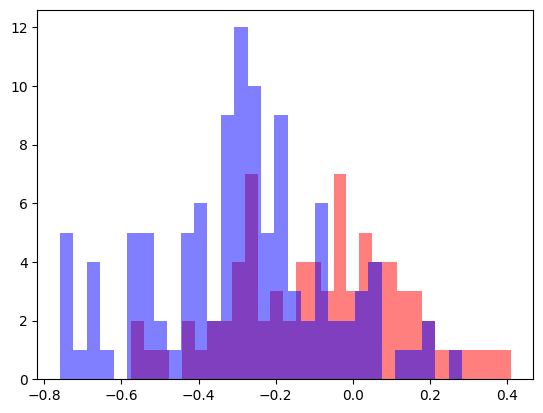

In [22]:
plot_axis_hist(227)

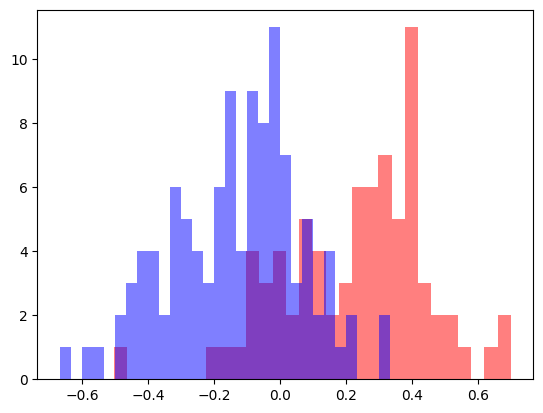

In [23]:
plot_axis_hist(44)

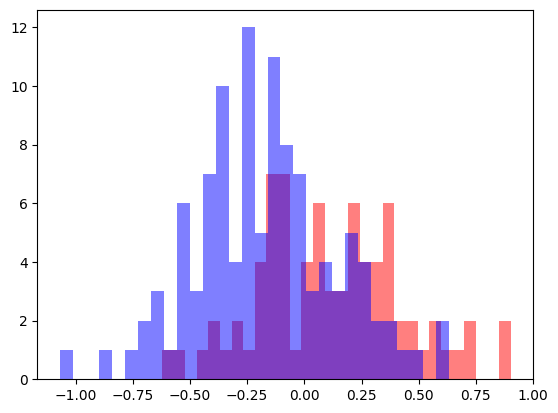

In [24]:
plot_axis_hist(0)